# 📚 LangGraph Learning - Persistence & Checkpointing Practice

This is my **practice notebook** while learning **LangGraph Persistence** for building fault-tolerant agentic AI workflows. Not a production project — just hands-on experimentation with **checkpointing, time travel, and failure recovery**! 🧪

## 🎯 What I'm Learning

- How to **persist state** across workflow executions
- **Checkpointing** with `InMemorySaver`
- **Time travel** — resuming from any previous checkpoint
- **Fault tolerance** — recovering from failures without losing progress
- **State modification** — updating state at specific checkpoints
- **Thread management** — organizing workflows by thread IDs

## 🧠 Concepts Practiced

| Concept | What I Learned |
|---------|----------------|
| `InMemorySaver` | In-memory checkpointer for development/testing |
| `thread_id` | Groups related checkpoints together |
| `checkpoint_id` | Unique identifier for each saved state |
| `get_state()` | Retrieve current state of a workflow |
| `get_state_history()` | Get all checkpoints for a thread |
| `update_state()` | Modify state at a specific checkpoint |
| `invoke(None, config)` | Resume workflow from last checkpoint |

## 🔬 What This Practice Code Does

### Part 1: Basic Persistence (Joke Generator)

```
Topic Input → Generate Joke → Explain Joke → Output
     ↓              ↓              ↓
 [Checkpoint]  [Checkpoint]   [Checkpoint]
```

- Each node saves a checkpoint automatically
- Can view entire state history
- Can resume or modify from any checkpoint

### Part 2: Fault Tolerance (Simulated Failures)

```
Fetch Data → Process Data (50% fail) → Format Output
     ↓              ↓                       ↓
 [Saved ✅]    [May Fail ❌]           [Saved ✅]
                   ↓
            [Retry from checkpoint]
```

- Simulates random failures at Step 2
- Automatically resumes from last successful checkpoint
- Retries until success or max attempts reached

## 🏗️ Graph Flows I Built

### Flow 1: Joke Generator with Persistence

```
        START
          │
          ▼
  ┌───────────────┐
  │ joke_generator│ → [Checkpoint 1]
  └───────┬───────┘
          │
          ▼
  ┌───────────────┐
  │ joke_explainer│ → [Checkpoint 2]
  └───────┬───────┘
          │
          ▼
         END      → [Checkpoint 3]
```

### Flow 2: Fault-Tolerant Pipeline

```
        START
          │
          ▼
    ┌──────────┐
    │  step1   │ ✅ Always succeeds
    └────┬─────┘
         │ [Checkpoint saved]
         ▼
    ┌──────────┐
    │  step2   │ ⚠️ 50% failure rate
    └────┬─────┘
         │ [If fails, retry from here]
         ▼
    ┌──────────┐
    │  step3   │ ✅ Always succeeds
    └────┬─────┘
         │
         ▼
        END
```

## 🛠️ Setup

```bash
# Install dependencies
pip install langgraph langchain-groq langchain-core python-dotenv

# Create .env file
echo "GROQ_API_KEY=your_key_here" > .env
```

## 📝 Key Code Snippets I Practiced

### 1. Setting Up Checkpointer

```python
from langgraph.checkpoint.memory import InMemorySaver

# Create checkpointer
checkpointer = InMemorySaver()

# Compile graph with checkpointer
workflow = graph.compile(checkpointer=checkpointer)
```

### 2. Running with Thread ID

```python
# Config with thread_id groups checkpoints together
config = {"configurable": {"thread_id": "1"}}

# Run workflow
result = workflow.invoke({"topic": "cat"}, config=config)
```

### 3. Viewing Current State

```python
# Get current state
current_state = workflow.get_state(config=config)
print(current_state.values)  # Current values
print(current_state.next)    # Next node to execute
```

### 4. Viewing State History

```python
# Get all checkpoints for this thread
history = list(workflow.get_state_history(config=config))

for state in history:
    print(f"Checkpoint: {state.config['configurable']['checkpoint_id']}")
    print(f"Values: {state.values}")
    print(f"Next: {state.next}")
```

### 5. Time Travel - Resume from Specific Checkpoint

```python
# Resume from a specific checkpoint
checkpoint_config = {
    "configurable": {
        "thread_id": "1",
        "checkpoint_id": "1f0d7f95-f573-6fe6-8001-79a8fbd8fe73"
    }
}

# Continue from that checkpoint
result = workflow.invoke(None, config=checkpoint_config)
```

### 6. Modifying State at Checkpoint

```python
# Update state at a specific checkpoint
workflow.update_state(
    config={
        "configurable": {
            "thread_id": "1",
            "checkpoint_id": "1f0d7f95-ee3a-6018-8000-e416a539277b",
            "checkpoint_ns": ""
        }
    },
    values={"topic": "tiger"}  # New values to set
)
```

### 7. Fault-Tolerant Retry Pattern

```python
config = {"configurable": {"thread_id": "fault-tolerant-1"}}
initial_state = {"data": "Python programming"}

# First attempt
try:
    result = workflow.invoke(initial_state, config=config)
except Exception as e:
    print(f"Failed: {e} - but state is saved!")

# Retry from checkpoint
max_retries = 5
for attempt in range(max_retries):
    try:
        result = workflow.invoke(None, config=config)  # None = resume
        print("Success!")
        break
    except Exception as e:
        print(f"Attempt {attempt + 1} failed, retrying...")
```

## 🔄 Time Travel Explained

```
Checkpoint Timeline:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ CP-1 │ CP-2 │ CP-3 │ CP-4 │ CP-5 │
│ cat  │ joke │ exp  │ tiger│ joke │
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
                       ↑
                 update_state()
                 (changed topic)
                       ↓
               ━━━━━━━━━━━━━━━━
               New branch created
```

**Key Insight**: `update_state()` creates a NEW checkpoint with modified values, allowing you to branch from any point in history!

## 🛡️ Fault Tolerance Pattern

```
Initial Run:
┌─────────────────────────────────────────────┐
│ Step 1 ✅ → Step 2 ❌ (FAILED!)             │
│     ↓           ↓                           │
│ [Saved]    [Not saved - failed]             │
└─────────────────────────────────────────────┘

Retry (invoke with None):
┌─────────────────────────────────────────────┐
│ [Resume from Step 1 checkpoint]             │
│              ↓                              │
│         Step 2 ✅ → Step 3 ✅ → END         │
└─────────────────────────────────────────────┘
```

## 📊 Checkpointer Options

| Checkpointer | Use Case | Persistence |
|--------------|----------|-------------|
| `InMemorySaver` | Development/Testing | Lost on restart |
| `SqliteSaver` | Local production | Persists to file |
| `PostgresSaver` | Production | Database storage |

## 📖 Resources I Used

- [LangGraph Persistence Docs](https://langchain-ai.github.io/langgraph/concepts/persistence/)
- [Checkpointing Guide](https://langchain-ai.github.io/langgraph/how-tos/persistence/)
- [Time Travel Tutorial](https://langchain-ai.github.io/langgraph/how-tos/time-travel/)

## 🚧 Next Steps

- [ ] Try `SqliteSaver` for file-based persistence
- [ ] Implement human-in-the-loop with checkpoints
- [ ] Build a chatbot with conversation memory
- [ ] Add branching workflows with state modification
- [ ] Explore `PostgresSaver` for production use

## 💡 Notes to Self

- **`thread_id`** — Groups related runs together (like a conversation ID)
- **`checkpoint_id`** — Unique ID for each saved state
- **`invoke(None, config)`** — Resumes from last checkpoint
- **`get_state_history()`** — Returns checkpoints in reverse order (newest first)
- **`update_state()`** — Creates a NEW checkpoint, doesn't modify existing one

## ⚠️ Gotchas I Encountered

1. **InMemorySaver data is lost on kernel restart** — Use SqliteSaver for persistence
2. **checkpoint_ns must be empty string** — Not `None`, use `""`
3. **History is reverse chronological** — Newest checkpoint first
4. **update_state creates new checkpoint** — It doesn't modify the old one
5. **Resume needs same thread_id** — Or it won't find the checkpoints

## 🎯 Real-World Use Cases

| Scenario | How Persistence Helps |
|----------|----------------------|
| **LLM API timeout** | Resume from last successful step |
| **User interruption** | Save progress, continue later |
| **A/B testing** | Branch from checkpoint, try different paths |
| **Debugging** | Replay exact state that caused error |
| **Long workflows** | Don't lose hours of work on failure |

---

*This is part of my Agentic AI learning journey — mastering persistence and fault tolerance! 🚀*

In [104]:
from langgraph.graph import StateGraph,START,END
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langgraph.checkpoint.memory import InMemorySaver
from typing import TypedDict
load_dotenv()
model=ChatGroq(model="openai/gpt-oss-20b")



In [105]:
class jokeState(TypedDict):
    topic:str
    joke:str
    explanation:str

In [106]:
def joke_generator(state:jokeState):
    prompt=f"generate a dark humor joke in the topic:{state["topic"]} "
    result=model.invoke(prompt)
    return {"joke":result.content}


In [107]:
def joke_explainer(state:jokeState):
    prompt=f"generate the  explaination of the joke \n:{state["joke"]} "
    result=model.invoke(prompt)
    return {"explanation":result.content}

In [108]:
graph=StateGraph(jokeState)
graph.add_node("joke_generator",joke_generator)
graph.add_node("joke_explainer",joke_explainer)

checkpointer=InMemorySaver()
graph.add_edge(START,"joke_generator")
graph.add_edge("joke_generator","joke_explainer")
graph.add_edge("joke_explainer",END)
workflow=graph.compile(checkpointer=checkpointer)

In [109]:
config1={"configurable":{"thread_id":"1"}}
inital_state={"topic":"cat"}
workflow.invoke(inital_state,config=config1)

{'topic': 'cat',
 'joke': 'Why did my cat bring a coffin to the vet?  \nBecause he heard the clinic was a *death row* for pets.',
 'explanation': '**Explanation of the joke**\n\n> **Why did my cat bring a coffin to the vet?  \n> Because he heard the clinic was a *death row* for pets.**\n\n| Element | What it means in the joke | How it creates humor |\n|---------|---------------------------|----------------------|\n| **“Death row”** | In real life, “death row” is the part of a prison where inmates are held while awaiting execution. | The phrase is a familiar legal term, so most people instantly picture a grim, final‑destination setting. |\n| **Vet clinic** | A place where animals receive medical care, usually to keep them healthy, not to kill them. | The joke flips the usual expectation: instead of a place of healing, the cat imagines it as a place of death. |\n| **Cat bringing a coffin** | Cats are often portrayed as cautious, suspicious, or “cat‑ish” when it comes to doctors. | The im

In [110]:
workflow.get_state(config=config1)

StateSnapshot(values={'topic': 'cat', 'joke': 'Why did my cat bring a coffin to the vet?  \nBecause he heard the clinic was a *death row* for pets.', 'explanation': '**Explanation of the joke**\n\n> **Why did my cat bring a coffin to the vet?  \n> Because he heard the clinic was a *death row* for pets.**\n\n| Element | What it means in the joke | How it creates humor |\n|---------|---------------------------|----------------------|\n| **“Death row”** | In real life, “death row” is the part of a prison where inmates are held while awaiting execution. | The phrase is a familiar legal term, so most people instantly picture a grim, final‑destination setting. |\n| **Vet clinic** | A place where animals receive medical care, usually to keep them healthy, not to kill them. | The joke flips the usual expectation: instead of a place of healing, the cat imagines it as a place of death. |\n| **Cat bringing a coffin** | Cats are often portrayed as cautious, suspicious, or “cat‑ish” when it comes t

In [111]:
list(workflow.get_state_history(config=config1)) 

[StateSnapshot(values={'topic': 'cat', 'joke': 'Why did my cat bring a coffin to the vet?  \nBecause he heard the clinic was a *death row* for pets.', 'explanation': '**Explanation of the joke**\n\n> **Why did my cat bring a coffin to the vet?  \n> Because he heard the clinic was a *death row* for pets.**\n\n| Element | What it means in the joke | How it creates humor |\n|---------|---------------------------|----------------------|\n| **“Death row”** | In real life, “death row” is the part of a prison where inmates are held while awaiting execution. | The phrase is a familiar legal term, so most people instantly picture a grim, final‑destination setting. |\n| **Vet clinic** | A place where animals receive medical care, usually to keep them healthy, not to kill them. | The joke flips the usual expectation: instead of a place of healing, the cat imagines it as a place of death. |\n| **Cat bringing a coffin** | Cats are often portrayed as cautious, suspicious, or “cat‑ish” when it comes 

# time travel 
>we dn continue the workflow from any node  

In [112]:
config2={"configurable":{"thread_id":"1"},"checkpoint_id":'1f0d7f95-f573-6fe6-8001-79a8fbd8fe73'}

In [113]:
workflow.update_state({"configurable":{"thread_id":"1"},"checkpoint_id":'1f0d7f95-ee3a-6018-8000-e416a539277b',"checkpoint_ns":''} ,{"topic":'tiger'})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0d7fcf-25c0-61de-8000-c3395e289e56'}}

In [114]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'tiger'}, next=('joke_generator',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0d7fcf-25c0-61de-8000-c3395e289e56'}}, metadata={'source': 'update', 'step': 0, 'parents': {}}, created_at='2025-12-13T08:23:04.633184+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0d7f95-ee3a-6018-8000-e416a539277b'}}, tasks=(PregelTask(id='c19287bd-a6dd-5b53-949f-28e8f4f4b6b4', name='joke_generator', path=('__pregel_pull', 'joke_generator'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'topic': 'cat', 'joke': 'Why did my cat bring a coffin to the vet?  \nBecause he heard the clinic was a *death row* for pets.', 'explanation': '**Explanation of the joke**\n\n> **Why did my cat bring a coffin to the vet?  \n> Because he heard the clinic was a *death row* for pets.**\n\n| Element | What it means in the joke | How it creates humor |\n|---

In [116]:
workflow.invoke( None,config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0d7fcf-25c0-61de-8000-c3395e289e56'}})

{'topic': 'tiger',
 'joke': 'Why did the tiger enroll in a grief counseling class?  \nBecause every time it caught a prey, it felt a little… *tiger* of guilt.',
 'explanation': '**Joke recap**\n\n> **Why did the tiger enroll in a grief‑counseling class?**  \n> Because every time it caught a prey, it felt a little… *tiger* of guilt.\n\n---\n\n### 1.  The set‑up\n\nThe joke starts with a classic “Why did ___ do ___?” question that sets up a situation that is **unexpected** and **anthropomorphic**.  \n- **Tiger**: a fierce predator, not something we normally think of as having emotions like guilt or needing therapy.  \n- **Grief‑counseling class**: a human activity that deals with emotional pain and loss.\n\nThe absurd image of a tiger going to a human counseling session already primes the listener for a twist.\n\n---\n\n### 2.  The punchline\n\n> “Because every time it caught a prey, it felt a little… *tiger* of guilt.”\n\nThe humor hinges on two things:\n\n| Element | What it does | Why

# fail tolerance through presisgance


In [117]:
import random

In [127]:
# State definition
class ProcessState(TypedDict):
    data: str
    step1_result: str
    step2_result: str
    step3_result: str
    error_count: int

In [128]:
# Step 1: Always succeeds
def step1_fetch_data(state: ProcessState):
    print(" Step 1: Fetching data...")
    result = model.invoke(f"Generate a short fact about: {state['data']}").content
    return {"step1_result": result}

In [129]:
# Step 2: Simulates random failure (50% chance)
def step2_process_data(state: ProcessState):
    print("Step 2: Processing data...")
    
    # Simulate random failure
    if random.random() < 0.5:
        print(" Step 2 FAILED! (Simulated error)")
        raise Exception("Simulated processing error!")
    
    result = model.invoke(f"Summarize this in one line: {state['step1_result']}").content
    print(" Step 2: Success!")
    return {"step2_result": result}

In [130]:
# Step 3: Final step
def step3_format_output(state: ProcessState):
    print(" Step 3: Formatting output...")
    result = f"📋 Final Result: {state['step2_result']}"
    return {"step3_result": result}

In [131]:
# Build the graph with checkpointing
graph = StateGraph(ProcessState)

graph.add_node("step1", step1_fetch_data)
graph.add_node("step2", step2_process_data)
graph.add_node("step3", step3_format_output)

graph.add_edge(START, "step1")
graph.add_edge("step1", "step2")
graph.add_edge("step2", "step3")
graph.add_edge("step3", END)

# 🔑 Key: Add checkpointer for persistence
checkpointer = InMemorySaver()
workflow = graph.compile(checkpointer=checkpointer)

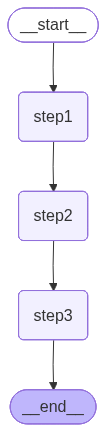

In [132]:
workflow

In [133]:

config = {"configurable": {"thread_id": "fault-tolerant-1"}}
initial_state = {"data": "Python programming"}

try:
    result = workflow.invoke(initial_state, config=config)
    print("\n Workflow completed successfully!")
    print(result)
except Exception as e:
    print(f"\n Workflow failed: {e}")
    print("But don't worry - state is saved!")

 Step 1: Fetching data...
Step 2: Processing data...
 Step 2 FAILED! (Simulated error)

 Workflow failed: Simulated processing error!
But don't worry - state is saved!


In [134]:
list(workflow.get_state_history({"configurable": {"thread_id": "fault-tolerant-1"}}))

[StateSnapshot(values={'data': 'Python programming', 'step1_result': 'Python was first released in 1991 by Guido van\u202fRossum and is known for its clear, readable syntax and extensive standard library.'}, next=('step2',), config={'configurable': {'thread_id': 'fault-tolerant-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0d7fd3-1510-65a6-8001-545cf70cc9c0'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-12-13T08:24:50.257636+00:00', parent_config={'configurable': {'thread_id': 'fault-tolerant-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0d7fd3-129b-64a6-8000-1e9aeb7bde04'}}, tasks=(PregelTask(id='d6e00d6d-1b90-c478-1cff-0d935b028572', name='step2', path=('__pregel_pull', 'step2'), error="Exception('Simulated processing error!')", interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'data': 'Python programming'}, next=('step1',), config={'configurable': {'thread_id': 'fault-tolerant-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0d7

In [135]:

print("\n Resuming workflow from last checkpoint...")

# Keep retrying until success
max_retries = 5
for attempt in range(max_retries):
    try: 
        print(f"\n--- Attempt {attempt + 1} ---")
        result = workflow.invoke(None, config=config)  # None = resume from checkpoint
        print("\n] Workflow completed successfully!")
        print(result)
        break
    except Exception as e:
        print(f" Attempt {attempt + 1} failed: {e}")
        if attempt < max_retries - 1:
            print("   Retrying from checkpoint...")


 Resuming workflow from last checkpoint...

--- Attempt 1 ---
Step 2: Processing data...
 Step 2 FAILED! (Simulated error)
 Attempt 1 failed: Simulated processing error!
   Retrying from checkpoint...

--- Attempt 2 ---
Step 2: Processing data...
 Step 2: Success!
 Step 3: Formatting output...

] Workflow completed successfully!
{'data': 'Python programming', 'step1_result': 'Python was first released in 1991 by Guido van\u202fRossum and is known for its clear, readable syntax and extensive standard library.', 'step2_result': 'Python, launched in 1991 by Guido van\u202fRossum, is celebrated for its clear, readable syntax and extensive standard library.', 'step3_result': '📋 Final Result: Python, launched in 1991 by Guido van\u202fRossum, is celebrated for its clear, readable syntax and extensive standard library.'}
